In [167]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Dirichlet, Uniform

In [168]:
def plot_ratio_with_mc_error(df, num_trials, numerator_col, denominator_col):
    """
    Plot ratio of two columns from a DataFrame with Monte Carlo error bars.

    Parameters:
    - df: pandas DataFrame containing the data
    - num_trials: int, number of Monte Carlo trials (used for estimating error bars)
    - numerator_col: str, name of the column to use as numerator
    - denominator_col: str, name of the column to use as denominator
    """
    ratio_col = "var_to_bound_ratio"
    error_col = "mc_std_err"

    # Compute ratio and standard error
    df[ratio_col] = df[numerator_col] / df[denominator_col]
    df[error_col] = df[ratio_col] / np.sqrt(num_trials)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(df["n"], df[ratio_col], yerr=df[error_col],
                 fmt='o-', capsize=4, label=f"{numerator_col} / {denominator_col}")
    plt.axhline(1.0, color='gray', linestyle='--', label='Ratio = 1')
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Ratio")
    plt.title("Ratio with Monte Carlo Error Bars")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

First we verify that CLT works for the linear regression problem $Y = XB + E$, where $B$ is a rotation matrix parametrized by $\theta$, and $E$ is a random matrix with i.i.d. $N(0, \sigma)$ entries. True $B$ is assumed to be $I_2$.

In particular, we want to compare the variance of $\theta$ and the predicted variance given by the curved Fisher's Information. 

In [169]:
def orthogonal_procrustes(X, Y, enforce_rotation=False):
    """
    Solves the orthogonal Procrustes problem:
        min_B || Y - X B ||_F^2
    subject to: B ∈ O_p (orthogonal matrix)
    
    Parameters:
        enforce_rotation (bool): If True, ensures det(B)=+1 (proper rotation)
        return_theta (bool): If True and B is 2x2, also return the angle θ (in radians)

    Returns:
        B (optimal orthogonal matrix)
        θ (optimal rotation angle)
    """
    M = X.T @ Y
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    B = U @ Vt

    if enforce_rotation:
        det = torch.linalg.det(B)
        if det < 0:
            Vt[-1, :] *= -1
            B = U @ Vt


    if B.shape != (2, 2):
        raise ValueError("return_theta=True is only supported for 2x2 matrices.")
    theta = torch.atan2(B[1, 0], B[0, 0])  # atan2(sinθ, cosθ)
    return B, theta

def rotation_matrix(theta):
    
    c, s = torch.cos(theta), torch.sin(theta)
    B =  torch.stack([
        torch.stack([c, -s]),
        torch.stack([s,  c])
    ])
    
    return B
    
def Curved_FI_rotation_lin_reg(X, sigma, theta):
    
    theta = torch.tensor(theta, dtype=X.dtype)
    c, s = torch.cos(theta), torch.sin(theta)
    B_deriv = torch.stack([
        torch.stack([-s, -c]),
        torch.stack([c,  -s])
    ])  # dB/dtheta
    I_curved = (1 / sigma**2) * torch.norm(X @ B_deriv, p = 'fro')**2
    
    return I_curved

def gen_Y(X, sigma, true_theta = 0):
    
    n, p = X.shape
    true_theta = torch.tensor(true_theta, dtype=X.dtype)
    normal = Normal(0, sigma)
    
    B = rotation_matrix(true_theta)
    noise = normal.sample((n, p))
    Y = X @ B + noise
    return(Y)

In [171]:
def rotation_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma = 0.02, true_theta = 0):
    unif = Uniform(0, 1)
    var_list = []
    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, 2))
        Curved_FI = Curved_FI_rotation_lin_reg(X, sigma, true_theta)
        theta_hat_list = []
        for _ in range(num_trials):
            Y = gen_Y(X, sigma, true_theta)
            B_hat, theta_hat = orthogonal_procrustes(X, Y, True)
            theta_hat_list.append(theta_hat)
        theta_var = {"n": n, 
                     "num_trials": torch.tensor(theta_hat_list).var().item(),
                     "inv_Curved_FI": (1/Curved_FI).item()}
        var_list.append(theta_var)
    df = pd.DataFrame(var_list)
    return(df)
            


In [172]:
num_trials = 10000
df_rotation = rotation_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

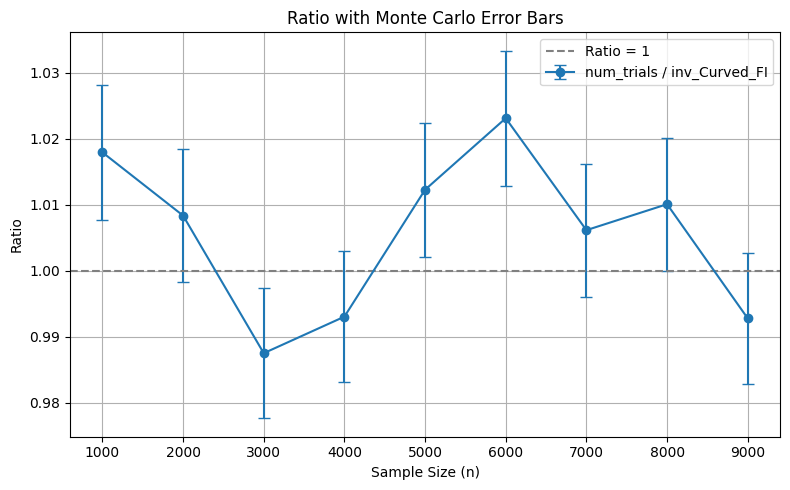

In [173]:
plot_ratio_with_mc_error(df_rotation, num_trials, "num_trials" , "inv_Curved_FI")

Now we move on to the same regression problem, but $B \in O_p$ instead of the rotation matrix constraint. $B$ can still be solved the same way, but due to the lack of parametrization, we have to replace the Jacobian of $B(\theta)$ with a matrix whose columns are orthonormal bases of $T_I(O_p)$ (since we are assuming that $B = I_2$).

In [174]:
def skew_symmetric_basis(p):
    """
    Returns a matrix whose columns are the vectorized orthonormal basis elements
    of the space of p x p skew-symmetric matrices.

    Output shape: (p^2, d), where d = p(p-1)/2
    """
    basis_list = []
    for i in range(p):
        for j in range(i+1, p):
            E = torch.zeros((p, p))
            E[i, j] = 1 / torch.sqrt(torch.tensor(2.0))
            E[j, i] = -1 / torch.sqrt(torch.tensor(2.0))
            basis_list.append(E.reshape(-1))  # vectorize

    basis_matrix = torch.stack(basis_list, dim=1)  # shape (p^2, d)
    return basis_matrix


def project_to_tangent_space(Delta, basis_matrix):
    """
    Project a matrix Delta onto the tangent space spanned by an orthonormal basis.
    
    Parameters:
        Delta         : (p x p) matrix of deviations (e.g., W_hat - I)
        basis_matrix  : (p^2 x d) matrix, each column is a vectorized orthonormal basis element of T_I(O_p)
    
    Returns:
        projection    : (p x p) matrix, projection of Delta into tangent space
        coeffs        : (d,) tensor, coefficients of Delta along each basis direction
    """
    p_squared, d = basis_matrix.shape
    Delta_vec = Delta.reshape(-1)                 # shape (p^2,)
    coeffs = basis_matrix.T @ Delta_vec           # shape (d,)
    projection_vec = basis_matrix @ coeffs        # shape (p^2,)
    projection_matrix = projection_vec.reshape(Delta.shape)  # shape (p x p)
    
    return projection_matrix, coeffs

def Curved_FI_Op_lin_reg(X, sigma):
    """
    Compute curved Fisher Information matrix for orthogonally constrained regression model.
    
    Parameters:
        X     : (n x p) design matrix
        sigma : noise std deviation

    Returns:
        FI_curved : (d x d) Fisher Information projected onto skew-symmetric tangent space
    """
    n, p = X.shape
    basis_mat = skew_symmetric_basis(p)  # (p^2 x d)
    
    FI_full = (1 / sigma**2) * torch.kron(torch.eye(p), X.T @ X)  # (p^2 x p^2)
    FI_curved = basis_mat.T @ FI_full @ basis_mat                 # (d x d)
    
    return FI_curved


def compute_empirical_cov(coeff_matrix):
    """
    Computes unbiased empirical covariance matrix for coeff_matrix (num_trials x d).
    """
    num_trials = coeff_matrix.shape[0]
    mean = coeff_matrix.mean(dim=0, keepdim=True)
    centered = coeff_matrix - mean
    cov = (centered.T @ centered) / (num_trials - 1)
    return cov

def Op_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    unif = Uniform(0, 1)
    var_list = []

    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, p))
        FI_curved = Curved_FI_Op_lin_reg(X, sigma)
        basis_mat = skew_symmetric_basis(p)

        coeff_matrix = []

        for _ in range(num_trials):
            Y = gen_Y(X, sigma)  # assumes default true_W = identity
            W_hat = orthogonal_procrustes(X, Y, enforce_rotation=False)[0]  # full O(p), not just rotation
            Delta = W_hat - torch.eye(p)
            _, coeffs = project_to_tangent_space(Delta, basis_mat)
            coeff_matrix.append(coeffs)

        coeff_matrix = torch.stack(coeff_matrix, dim=0)  # shape (num_trials x d)
        empirical_cov = compute_empirical_cov(coeff_matrix)  # (d x d)

        var_record = {
            "n": n,
            "empirical_cov_trace": empirical_cov.trace().item(),
            "inv_Curved_FI_trace": torch.linalg.inv(FI_curved).trace().item()
        }
        var_list.append(var_record)

    df = pd.DataFrame(var_list)
    return df

In [175]:
num_trials = 10000
df_Op = Op_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

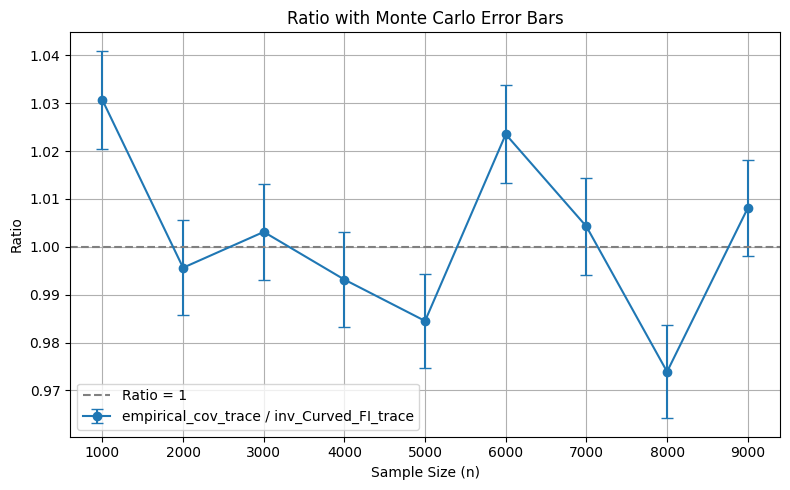

In [179]:
plot_ratio_with_mc_error(df_Op, num_trials, "empirical_cov_trace", "inv_Curved_FI_trace")

In [181]:
class GaussianPenaltyLoss2D(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma
        self.theta = nn.Parameter(torch.tensor(0.0))  # learnable scalar angle
        self.normal = Normal(0, sigma)

    def rotation_matrix(self):
        c = torch.cos(self.theta)
        s = torch.sin(self.theta)
        return torch.stack([
            torch.stack([c, -s]),
            torch.stack([s,  c])
        ])  # shape (2 x 2)

    def forward(self, Z):
        """
        Z: (n x 2) matrix — each row is a vector z
        Returns: scalar total loss over all rows
        """
        V = self.rotation_matrix()     # (2 x 2)
        VZ = Z @ V.T                   # (n x 2)
        scaled = VZ / self.sigma       # (n x 2)

        phi = self.normal.log_prob(-scaled).exp()
        Phi = self.normal.cdf(-scaled)

        loss_per_row = torch.sum(phi - scaled * Phi, dim=1) * self.sigma
        total_loss = loss_per_row.sum()
        return total_loss

    def optimize_theta(self, Z, steps=200, lr=0.1):
        """
        Optimize theta using LBFGS given data Z.
        """
        optimizer = optim.LBFGS([self.theta], lr=lr, max_iter=20, history_size=10)

        def closure():
            optimizer.zero_grad()
            loss = self.forward(Z)
            loss.backward()
            return loss

        for step in range(steps):
            optimizer.step(closure)

        return self.theta

In [186]:
unif = Uniform(0, 1)
Z = unif.sample((10000, 2))
model = GaussianPenaltyLoss2D(sigma=0.5)

# Before optimization
print("Initial theta:", model.theta.item())

# Optimize
theta_final = model.optimize_theta(Z)

print("Optimized theta:", theta_final.item())

Initial theta: 0.0
Optimized theta: 0.0023528707679361105
